# Load packages and data 

In [1]:
import pylab as pl 
import numpy as np 
import pandas as pd 
import geopandas as gp 
import warnings
warnings.filterwarnings('ignore')
from multiprocessing import Pool

# Conflate with NHD low res

This one is done to obtain the conflation with the NHD network used by the NWC model 

In [310]:
def nhd2hlm(comid, max_uparea_diff=0.6, min_intercept=0.015, verbose = False, buffer = 20):
    #try:
    #Get the NHD link corresponding to the comid, its name, and creates a buffer of it
    name = nhd.loc[nhd.COMID == comid,'GNIS_NAME'].values[0]
    _tnhd = nhd.loc[nhd['COMID'] == comid]
    nhd_b = _tnhd.buffer(buffer)
    nhd_b = gp.GeoDataFrame(_tnhd['COMID'], geometry = nhd_b.geometry)
    if verbose:
        print('1. buffer for the nhd done')

    #Overlap both buffers
    bounds = list(nhd_b.bounds.values[0])
    hlm_candidates = list(hlm_b.sindex.intersection(bounds))
    union = gp.overlay(nhd_b, hlm_b.loc[hlm_candidates], how='union', )
    #union = gp.overlay(nhd_b, hlm_b, how='union', )
    river = union.loc[((~union['COMID'].isnull())&(~union['LINKNO'].isnull()))]
    river['area'] = river.area
    #Clean the river removing the elements with almost no interception
    river['p_area'] = river['area'] / river['area'].sum()
    river.drop(river.loc[river['p_area'] < min_intercept].index, inplace=True)
    
    #Works if there is an intersection
    if river.shape[0] > 0:
        
        if verbose:
            print('2. buffer union, done')

        #set a temporal network of hlm taking the intersection 
        a = hlm_l.copy()#hlm.set_index('link')
        a = a.loc[river.LINKNO]
        a.drop_duplicates(inplace=True)
        
        #Clean up tributaries that do not belong to the main channel
        flag = True
        while flag:
            to_remove = []
            for link in river.LINKNO.unique():
                try:
                    hlm_uparea = a.loc[link,'USContArea'].values[0] / 1e6
                except:
                    hlm_uparea = a.loc[link,'USContArea']/ 1e6
                errors = []
                for i in river.loc[river.LINKNO == link, 'COMID']:
                    nhd_uparea = nhd.loc[nhd.COMID == int(i),'TotDASqKM'].values[0]
                    errors.append(np.abs((nhd_uparea - hlm_uparea)/nhd_uparea))
                if np.min(errors) > max_uparea_diff:
                    to_remove.append(link)
            if len(to_remove) < 0.5*a.shape[0]:
                flag = False
            else:
                max_uparea_diff += 0.2
                if verbose:
                    print('max_uparea_diff increased to %.1f' % max_uparea_diff)
            if max_uparea_diff > 1.0:
                flag = False
                break 
        a = a.drop(to_remove)
        a.drop_duplicates(inplace=True)
        if verbose:
            print('3. Clean hlm tributaries, done')
        
        if a.shape[0]>0:
            #Get the most upstream reach
            link_in = int(a[a.USContArea == a.USContArea.min()].index[0])
            link_out = int(a.sort_values('USContArea').index[-1])
            flag = True
            cont = 2
            while flag:
                try:        
                    #Goes downstream in the original hlm network to add those
                    links_to_add = []
                    dslink = link_in
                    while dslink != link_out:
                        #Search the next link in the temporal network
                        try:
                            dslink = a.loc[dslink,'ds']
                        except:
                            links_to_add.append(dslink)
                            dslink = hlm_l.loc[dslink,'ds']
                    #Final dataframe with the links that belong to the otter river        
                    b = pd.concat([hlm_l.loc[links_to_add], a])
                    flag = False
                except:
                    link_out = int(a.sort_values('USContArea').index[-cont])
                    cont+=1
            if verbose:
                print('4. Fill gaps in the process, done')
            b['COMID'] = comid
            b['name'] = name

            idx = river.set_index('LINKNO').index.intersection(b.index)
            b['p_area'] = 0
            b.loc[idx, 'p_area'] = river.set_index('LINKNO').loc[idx]

            return b
        else:
            return 0
    else:
        return 0
    # except:
    #     pass

In [3]:
hlm = gp.read_file('../local_data/vector/network_conflation.shp')
nhd = gp.read_file('../local_data/vector/nhd_for_iowa_proj.shp')

## Processing the network 

### Example processing one comid at the time 

In [24]:
#Read the nhd+ network
#nhd = gp.read_file('../local_data/vector/nhd_for_iowa_proj.shp')
nhd.set_index('COMID', inplace = True)
nhd['COMID'] = nhd.index
nhd_b = nhd.buffer(10)
nhd_b = gp.GeoDataFrame(nhd['COMID'], geometry=nhd_b.geometry)

#Read the hlm network
#hlm = gp.read_file('../local_data/vector/network_conflation.shp')
#hlm = hlm.loc[hlm['strmOrder'] > 1]
hlm_l = hlm.set_index('LINKNO')

#Hlm network buffer
hlm_b = hlm.buffer(10)
hlm_b = gp.GeoDataFrame(hlm['LINKNO'], geometry = hlm_b.geometry)

In [295]:
b1 = nhd2hlm(6602956, max_uparea_diff=0.6, buffer=10)
b2 = nhd2hlm(6602908, max_uparea_diff=0.6, buffer=10)
b3 = nhd2hlm(6602896, max_uparea_diff=0.6, buffer=10)

In [296]:
b = pd.concat([b1,b2])
b['LINKNO'] = b.index
b.set_index(['LINKNO', 'COMID'], inplace = True)

#Iterates and if the index is repeated, holds the one with the larger intersection
for lid, evaluate in zip(b.index.get_level_values(0), b.index.get_level_values(0).duplicated()):
    if evaluate:
        #Organizes the slice in function of the intersected area (the best remains the last)
        _b = b.loc[lid].sort_values('p_area')
        #Drops all the remaining combinations that have that lid
        for bad_comid in _b.index.values[:-1]:
            b.drop(index=(lid, bad_comid), inplace=True)
b['COMID'] = b.index.get_level_values('COMID')

<Axes: >

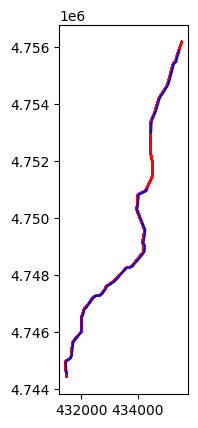

In [298]:
fig = pl.figure()
ax = fig.add_subplot(111)
nhd.loc[b['COMID']].plot(ax = ax, color = 'r')
b.plot(ax = ax, color = 'b')

In [306]:
link_s = b.sort_values('DSContArea').index.get_level_values('LINKNO')[0]
link_e = b.sort_values('DSContArea').index.get_level_values('LINKNO')[-1]

In [309]:
hlm_l.loc[link_e]

DSNODEID                                                     -1
strmOrder                                                     5
Length                                                    555.6
Magnitude                                                   210
DSContArea                                           60607564.0
strmDrop                                                   0.76
Slope                                                   0.00137
StraightL                                                 510.9
USContArea                                           60574364.0
WSNO                                                    1745530
DOUTEND                                                603205.5
DOUTSTART                                              603760.9
DOUTMID                                                603483.2
np                                                            2
us1                                                     1713497
us2                                     

## Processing all of it in parallel 

In [311]:
steps = np.arange(0, nhd.shape[0], step = 5000).tolist()
steps.append(nhd.shape[0])

c = 1
for step1 , step2 in zip(steps[:-1], steps[1:]):

    p = Pool(12)
    b = p.map(nhd2hlm, nhd.index.tolist()[step1:step2])
    p.close()
    p.join()

    b = [i for i in b if type(i)!=int]    

    #Creates a data frame where the first index is the lid and the second the comid
    b = pd.concat(b)
    b['LINKNO'] = b.index
    b.set_index(['LINKNO', 'COMID'], inplace = True)

    #Iterates and if the index is repeated, holds the one with the larger intersection
    for lid, evaluate in zip(b.index.get_level_values(0), b.index.get_level_values(0).duplicated()):
        if evaluate:
            #Organizes the slice in function of the intersected area (the best remains the last)
            _b = b.loc[lid].sort_values('p_area')
            #Drops all the remaining combinations that have that lid
            for bad_comid in _b.index.values[:-1]:
                b.drop(index=(lid, bad_comid), inplace=True)
    #Reset the indexes so they will show up in the shapefile 
    b.reset_index()
    b.to_file('../local_data/vector/confalte_%d.shp' % c)
    c+=1
    print(step2)

5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
76394


After this step, I merged the conflated files in Qgis and exported just the LINKNO and COMID as a csv file, with that one I performed the next step 

## Filling holes downstream

In [45]:
#REad the data 
con =pd.read_csv('../local_data/tables/conflated.csv')
net = pd.read_csv('../local_data/tables/network_conflation.csv')
con.set_index('LINKNO', inplace = True)
net.set_index('LINKNO', inplace = True)

net.loc[con.index, 'COMID'] = con['COMID']

In [48]:
con

,COMID,DSContArea
LINKNO,,
1760512,2748946,352408032.0
1760288,2750214,352131712.0
1673825,2750230,80090680.0
1674049,2750230,81018488.0
1730050,2750230,83520904.0
...,...,...
1019172,22255981,874705.2
1276548,22256221,967305.8
1340836,22255975,2382614.2


In [ ]:
def conflation_gap_fixer(lid):
    flag = True
    to_fix = []
    fix_val = -999
    while flag:
        lid = net.loc[lid, 'ds']        
        if lid > 0:
            comid = net.loc[lid,'COMID']
            if np.isnan(comid):
                to_fix.append(lid)
            else:
                fix_val = comid
                flag = False
        else:
            return [], -9
    return to_fix, fix_val

In [ ]:
con.sort_values('DSContArea', inplace = True)
for lid in con.index:
    if net.loc[lid, 'ds'] > 0:
        to_fix , fix_val = conflation_gap_fixer(lid)
        if len(to_fix) > 0:
            net.loc[to_fix,'COMID'] = fix_val
            #print('lid %d filled %d links with comid: %d' % (lid, len(to_fix), fix_val))
net.reset_index(inplace = True)
net[['LINKNO','COMID']].to_csv('../local_data/tables/conflated_filled.csv')

# Conflate with NHD HD using the GNISID and GNISNAME

This step is done to obtain the names of the rivers that have name some stuff changes in the function definition 

In [198]:
def nhd2hlm_w_gnisid(nhd_id, max_uparea_diff=0.3, min_intercept=0.015, verbose = False, buffer = 10):
    name = nhd.loc[nhd.NHDPlusID == nhd_id,'GNIS_Name'].values[0]
    gnis_id = nhd.loc[nhd.NHDPlusID == nhd_id,'GNIS_ID'].values[0]

    _tnhd = nhd.loc[nhd['NHDPlusID'] == nhd_id]
    nhd_b = _tnhd.buffer(buffer)
    nhd_b = gp.GeoDataFrame(_tnhd['NHDPlusID'], geometry = nhd_b.geometry)
    if verbose:
        print('1. buffer for the nhd done')

    #Overlap both buffers
    bounds = list(nhd_b.bounds.values[0])
    hlm_candidates = list(hlm_b.sindex.intersection(bounds))
    union = gp.overlay(nhd_b, hlm_b.loc[hlm_candidates], how='union', )
    #union = gp.overlay(nhd_b, hlm_b, how='union', )
    river = union.loc[((~union['NHDPlusID'].isnull())&(~union['LINKNO'].isnull()))]
    river['area'] = river.area
    #Clean the river removing the elements with almost no interception
    river['p_area'] = river['area'] / river['area'].sum()
    river.drop(river.loc[river['p_area'] < min_intercept].index, inplace=True)

    #Works if there is an intersection
    if river.shape[0] > 0:

        if verbose:
            print('2. buffer union, done')

        #set a temporal network of hlm taking the intersection 
        a = hlm_l.copy()#hlm.set_index('link')
        a = a.loc[river.LINKNO]
        a.drop_duplicates(inplace=True)

        #Clean up tributaries that do not belong to the main channel
        flag = True
        while flag:
            to_remove = []
            for link in river.LINKNO.unique():
                try:
                    hlm_uparea = a.loc[link,'USContArea'].values[0] / 1e6
                except:
                    hlm_uparea = a.loc[link,'USContArea']/ 1e6
                errors = []
                for i in river.loc[river.LINKNO == link, 'NHDPlusID']:
                    nhd_uparea = nhd.loc[nhd.NHDPlusID == i,'TotDASqKm'].values[0]
                    errors.append(np.abs((nhd_uparea - hlm_uparea)/nhd_uparea))
                if np.min(errors) > max_uparea_diff:
                    to_remove.append(link)
            if len(to_remove) < 0.5*a.shape[0]:
                flag = False
            else:
                max_uparea_diff += 0.2
                if verbose:
                    print('max_uparea_diff increased to %.1f' % max_uparea_diff)
            if max_uparea_diff > 1.0:
                flag = False
                break 
        a = a.drop(to_remove)
        a.drop_duplicates(inplace=True)
        if verbose:
            print('3. Clean hlm tributaries, done')

        if a.shape[0]>0:
            #Get the most upstream reach
            link_in = int(a[a.USContArea == a.USContArea.min()].index[0])
            link_out = int(a.sort_values('USContArea').index[-1])
            flag = True
            cont = 2
            while flag:
                try:        
                    #Goes downstream in the original hlm network to add those
                    links_to_add = []
                    dslink = link_in
                    while dslink != link_out:
                        #Search the next link in the temporal network
                        try:
                            dslink = a.loc[dslink,'ds']
                        except:
                            links_to_add.append(dslink)
                            dslink = hlm_l.loc[dslink,'ds']
                    #Final dataframe with the links that belong to the otter river        
                    b = pd.concat([hlm_l.loc[links_to_add], a])
                    flag = False
                except:
                    link_out = int(a.sort_values('USContArea').index[-cont])
                    cont+=1
            if verbose:
                print('4. Fill gaps in the process, done')
            b['NHDPlusID'] = nhd_id
            b['GNIS_ID'] = int(gnis_id)
            b['name'] = name

            idx = river.set_index('LINKNO').index.intersection(b.index)
            b['p_area'] = 0
            b.loc[idx, 'p_area'] = river.set_index('LINKNO').loc[idx]

            return b.reset_index()[['LINKNO', 'NHDPlusID','name','p_area','GNIS_ID']]
        else:
            return 0
    else:
        return 0

In [196]:
b = nhd2hlm_w_gnisid(22000300069850.003906250000000)

In [197]:
b

,LINKNO,NHDPlusID,name,p_area,GNIS_ID
0,1913343,2.200030e+13,Iowa River,0.765352,457834


<Axes: >

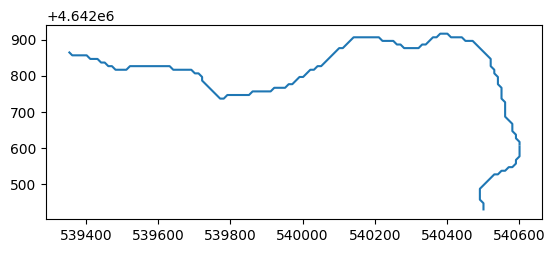

In [191]:
hlm_l.loc[b.LINKNO].plot()

In [3]:
hlm = gp.read_file('../local_data/vector/network_conflation.shp')
nhd = gp.read_file('../local_data/vector/nhd_hd_for_iowa_names_w_gnis.shp')

#Hlm network buffer
hlm_b = hlm.buffer(10)
hlm_b = gp.GeoDataFrame(hlm['LINKNO'], geometry = hlm_b.geometry)
hlm_l = hlm.set_index('LINKNO')

In [170]:
hlm_l.set_index('LINKNO', inplace = True)

## Conflation in parallel

In [199]:
#Assigns the NHD Id to each link id (one to many)
p = Pool(12)
b = p.map(nhd2hlm_w_gnisid, nhd['NHDPlusID'])
p.close()
p.join()
#Takes only the cases with sucess
b = [i for i in b if type(i)!=int]    
b = pd.concat(b)
#Sorth the values by the shared area and then excludes all the repeated links with lower shared area
b.sort_values('p_area', inplace = True, ascending = False)
b.drop_duplicates(subset='LINKNO', keep='first', inplace = True)
#Saves the results to a table
b.to_csv('../local_data/tables/conflated_nhd_hd3.csv')

## Fill gaps downstream 

In [150]:
def conflation_gap_fixer_hd(lid):
    flag = True
    to_fix = []
    fix_val = -999
    while flag:
        lid = hlm_l.loc[lid, 'ds']        
        if lid > 0:
            comid = hlm_l.loc[lid,'NHDPlusID']
            if np.isnan(comid):
                to_fix.append(lid)
            else:
                fix_val = comid
                flag = False
        else:
            return [], -9
    return to_fix, fix_val

In [159]:
#b.set_index('LINKNO', inplace = True)
hlm_l = hlm.set_index('LINKNO')
idx = hlm_l.index.intersection(b.index)
hlm_l.loc[idx, 'NHDPlusID'] = b.loc[idx, 'NHDPlusID']

In [148]:
b.set_index('LINKNO', inplace = True)

In [164]:
hlm_l.sort_values('DSContArea', inplace = True)
for lid in b.index:
    if hlm_l.loc[lid, 'ds'] > 0:
        to_fix , fix_val = conflation_gap_fixer_hd(lid)
        if len(to_fix) > 0:
            hlm_l.loc[to_fix,'NHDPlusID'] = fix_val

In [166]:
hlm_l['GNIS_ID'] = -9
hlm_l['name'] = -9
hlm_l.reset_index(inplace=True)
hlm_l.set_index('NHDPlusID', inplace = True)
nhd_ids = np.unique(b['NHDPlusID'])
b.reset_index(inplace= True)
b.set_index('NHDPlusID', inplace = True)

for i in nhd_ids:
    try:
        hlm_l.loc[i,'GNIS_ID'] = b.loc[i,'GNIS_ID'].values[0]
        hlm_l.loc[i,'name'] = b.loc[i,'name'].values[0]
    except:
        hlm_l.loc[i,'GNIS_ID'] = b.loc[i,'GNIS_ID']
        hlm_l.loc[i,'name'] = b.loc[i,'name']
        
hlm_l.reset_index(inplace = True)
hlm_l.loc[np.isfinite(hlm_l.NHDPlusID), ['LINKNO','NHDPlusID','GNIS_ID','name']].to_csv('../local_data/tables/conflated_nhd_hd2.csv')

In [124]:
b.reset_index().to_csv('../local_data/tables/conflated_nhd_hd_temp.csv')